In [312]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fftshift, fft2
import cv2

In [313]:
I = 1j
PI = np.pi

WAVELENGTH = 632.8e-9 # m
F_NUMBER = 1
FOCAL_DISTANCE = 150e-3 # m

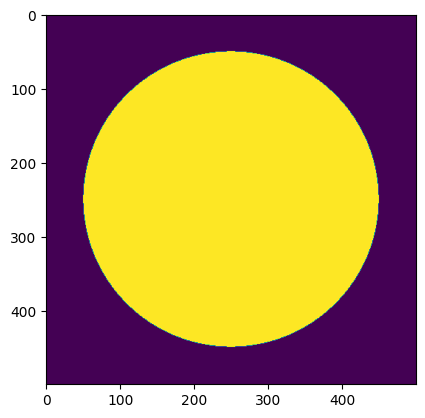

In [314]:
Ne = 512
zoom = 3
N_phi = Ne//(2**zoom)

R = 4

x = y = np.linspace(-5, 5, 500)
X, Y = np.meshgrid(x, y)
phi = np.ones_like(X)
phi[X**2+Y**2 > R**2] = 0
plt.imshow(phi)

phi = phi*np.exp(2*I*PI*((3 * X**2 + Y**2) * X / R**3)*0.4)

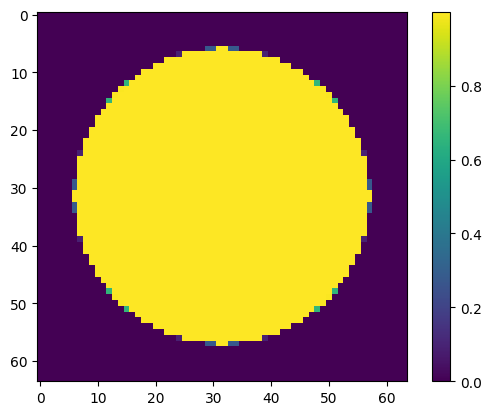

In [315]:
dim_y, dim_x = phi.shape
phi_reshaped_real_part = cv2.resize(np.real(phi), (N_phi, N_phi), interpolation=cv2.INTER_LINEAR)
phi_reshaped_imaginary_part = cv2.resize(np.imag(phi), (N_phi, N_phi), interpolation=cv2.INTER_LINEAR)
phi_reshaped = phi_reshaped_real_part + I* phi_reshaped_imaginary_part

phi_reshaped[np.isnan(phi_reshaped)] = 0
plt.imshow(np.abs(phi_reshaped))
plt.colorbar()

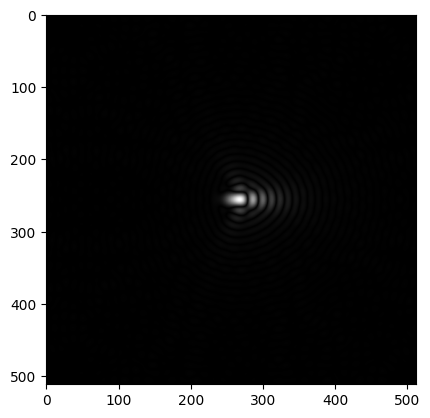

In [316]:
plt.imshow(np.abs(fftshift(fft2(phi_reshaped, (Ne, Ne)))), 'gray')

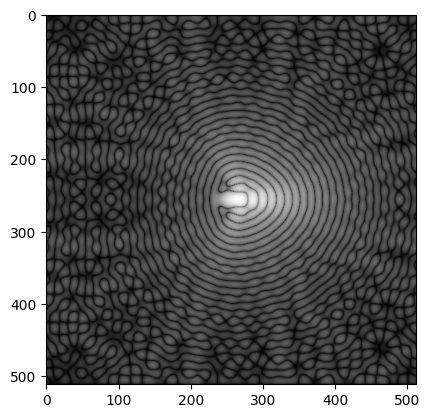

In [317]:
plt.imshow(np.log10(1+np.abs(fftshift(fft2(phi_reshaped, (Ne, Ne))))), 'gray')

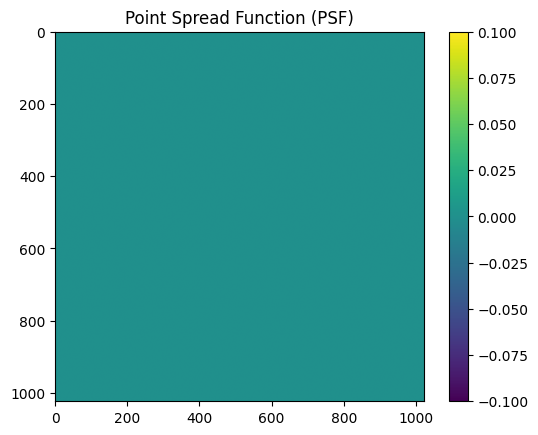

In [318]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fftshift, fft2
import cv2

PI = np.pi
I = 1j


def get_psf(phi, zoom, Ne):
    # Calculating necessary parameters
    N_phi = Ne // (2 ** zoom)

    # Resizing phi
    phi_reshaped = cv2.resize(phi, (N_phi, N_phi), interpolation=cv2.INTER_LINEAR)
    phi_reshaped[np.isnan(phi_reshaped)] = 0
    
    # Performing Fourier transform and obtaining PSF
    psf = np.abs(fftshift(fft2(phi_reshaped, (Ne, Ne))))
    
    return psf

# Constants
WAVELENGTH = 632.8e-9  # m
F_NUMBER = 2
FOCAL_DISTANCE = 150e-3  # m
Ne = 1024
zoom = 4

R = 1/2 * FOCAL_DISTANCE/F_NUMBER
# Generating the phase mask phi
x = y = np.linspace(-5, 5, 500)
X, Y = np.meshgrid(x, y)
phi = np.ones_like(X)
phi[X**2 + Y**2 > R**2] = 0

# Example usage
psf = get_psf(phi, zoom, Ne)

# Plotting the PSF
plt.imshow(psf)
plt.title('Point Spread Function (PSF)')
plt.colorbar()
plt.show()

***

(1024, 1024)


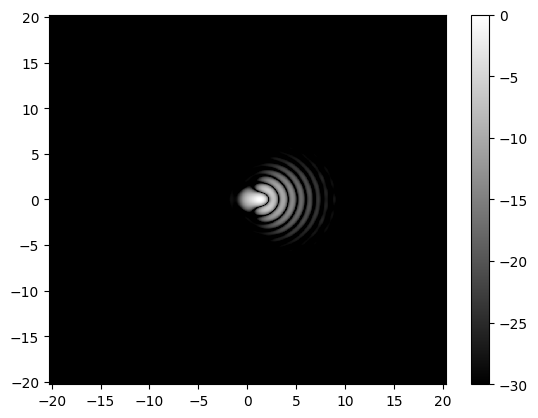

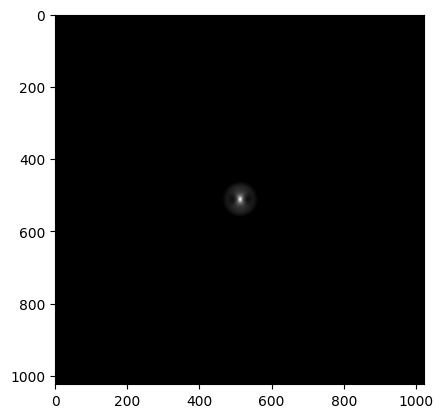

In [319]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fftshift, fft2
import cv2

I = 1j
PI = np.pi

WAVELENGTH = 632.8e-9 # m
F_NUMBER = 1
FOCAL_DISTANCE = 150e-3 # m

x = y = np.linspace(-5, 5, 500)
X, Y = np.meshgrid(x, y)

R = 4

phi = np.ones_like(X)
phi[X**2+Y**2 > R**2] = 0

phi = phi *np.exp(2*I*PI*(np.sqrt(8)*X*(X**2+Y**2)-2)*0.007)

def get_psf(wavefront, Ne, zoom):
    N_phi = Ne//(2**zoom)

    phi_reshaped_real_part = cv2.resize(np.real(wavefront), (N_phi, N_phi), interpolation=cv2.INTER_LINEAR)
    phi_reshaped_imaginary_part = cv2.resize(np.imag(wavefront), (N_phi, N_phi), interpolation=cv2.INTER_LINEAR)
    phi_reshaped = phi_reshaped_real_part + I* phi_reshaped_imaginary_part

    phi_reshaped[np.isnan(phi_reshaped)] = 0

    psf = np.abs(fftshift(fft2(phi_reshaped, (Ne, Ne))))**2
    psf /= psf.max()
    return psf

def get_mtf(wavefront, Ne, zoom):
    psf = get_psf(wavefront, Ne, zoom)
    mtf = fftshift(fft2(psf))
    mtf = np.abs(mtf)
    mtf /= mtf.max()
    return mtf

psf = get_psf(phi, 1024, 4)
seuil_dB = -30
seuil_gain = 10**(seuil_dB/10)
psf[psf<seuil_gain] = seuil_gain
psf = 10*np.log10(psf)

x_psf = y_psf = np.linspace(-1e6*WAVELENGTH*F_NUMBER*N_phi/2, 1e6*WAVELENGTH*F_NUMBER*N_phi/2, Ne)
print(psf.shape)
# x_psf, y_psf = np.meshgrid(x_psf, y_psf)
plt.pcolormesh(x_psf, y_psf, psf, cmap='gray'); plt.colorbar(); plt.show()

mtf = get_mtf(phi, 1024, 4)
plt.imshow(mtf, 'gray'); plt.show()

## Calcul de la taille d'un pixel dans l'espace de la PSF

L'équation 

$ \text{Ne} \cdot d_{\text{PSF}} = N_{\phi} \cdot (\lambda \cdot N_{\text{ouverture}}) $

exprime une relation importante entre la taille des pixels dans le plan de phase et la taille des pixels dans la PSF. Pour comprendre cette relation, nous devons examiner quelques concepts clés dans l'optique de Fourier et les transformations entre le plan pupillaire et le plan image.

### Concepts Clés

1. **Plan Pupillaire et Plan Image**:
   - Le plan pupillaire est l'endroit où se trouve l'ouverture de l'optique.
   - Le plan image est l'endroit où l'image est formée après la focalisation de la lumière par le système optique.

2. **Transformation de Fourier**:
   - La transformation de Fourier est utilisée pour passer du plan pupillaire (entrée) au plan image (sortie).

3. **Échantillonnage et Résolution**:
   - $ N_{\phi} $ est le nombre de pixels dans la grille de phase (plan pupillaire).
   - $ \text{Ne} $ est le nombre de pixels dans la grille de la PSF (plan image).
   - $ d_{\text{phase}} $ est la dimension d'un pixel dans la grille de phase.
   - $ d_{\text{PSF}} $ est la dimension d'un pixel dans la grille de la PSF.

### Relation de l'Échantillonnage

En utilisant la théorie de la diffraction et les propriétés de la transformation de Fourier, la taille des pixels dans le plan pupillaire et le plan image sont liées par une constante qui dépend de la longueur d'onde ( $ \lambda $ ) et du nombre d'ouverture ( $ N_{\text{ouverture}} $ ):

$ d_{\text{PSF}} = \frac{\lambda \cdot N_{\text{ouverture}}}{N_{\phi}} $

Cela signifie que pour chaque pixel dans le plan pupillaire, la PSF correspond à une aire plus grande dans le plan image en raison de la diffraction.

### Déduction de l'Équation

1. **Taille de l'ouverture et diamètre pupillaire**:
   $ D = \frac{f}{N_{\text{ouverture}}} $
   où $ f $ est la distance focale.

2. **Taille d'un pixel dans le plan pupillaire**:
   $ d_{\text{phase}} = \frac{D}{N_{\phi}} $

3. **Taille d'un pixel dans le plan image (PSF)**:
   En utilisant la théorie de la diffraction et la relation entre le plan pupillaire et le plan image,
   $ d_{\text{PSF}} = \frac{\lambda \cdot f}{D} $
   en substituant $ D = \frac{f}{N_{\text{ouverture}}} $,
   $ d_{\text{PSF}} = \lambda \cdot N_{\text{ouverture}} $

4. **Nombre total de pixels dans chaque dimension**:
   Le nombre total de pixels dans chaque dimension pour la PSF est $ \text{Ne} $, donc la relation est:
   $ \text{Ne} \cdot d_{\text{PSF}} = N_{\phi} \cdot d_{\text{phase}} $
   en substituant $ d_{\text{phase}} $ et $ d_{\text{PSF}} $,
   $ \text{Ne} \cdot (\lambda \cdot N_{\text{ouverture}}) = N_{\phi} \cdot \frac{D}{N_{\phi}} $
   en simplifiant,
   $ \text{Ne} \cdot d_{\text{PSF}} = N_{\phi} \cdot (\lambda \cdot N_{\text{ouverture}}) $

### Explication

Cette relation montre que la taille du pixel dans le plan image (PSF) est déterminée par la taille du pixel dans le plan pupillaire et les paramètres optiques tels que la longueur d'onde et le nombre d'ouverture. Cela permet de s'assurer que l'échantillonnage dans le plan image est suffisant pour capturer tous les détails importants de la PSF générée par le système optique.


1024 4 64
(1024, 1024)


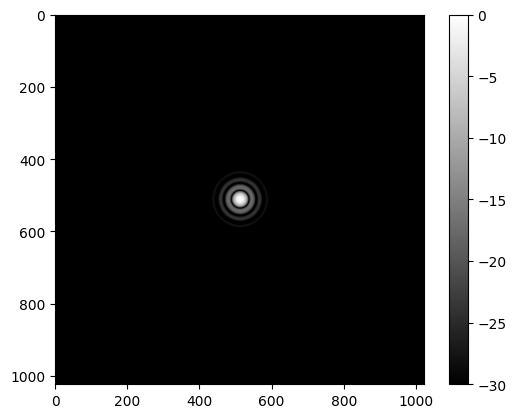

In [321]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fftshift, fft2
import cv2

PI = np.pi
I = 1j

x = y = np.linspace(-5, 5, 500)
X, Y = np.meshgrid(x, y)
phase_test = np.ones_like(X)
phase_test[X**2 + Y**2 > 4**2] = 0
phi = phase_test

def get_psf(wavefront, zoom, Ne):
    # Calculating necessary parameters
    N_phi = int(Ne // (2 ** zoom))
    print(Ne, zoom, N_phi)

    phi_reshaped_real_part = cv2.resize(np.real(wavefront), (N_phi, N_phi), interpolation=cv2.INTER_LINEAR)
    phi_reshaped_imaginary_part = cv2.resize(np.imag(wavefront), (N_phi, N_phi), interpolation=cv2.INTER_LINEAR)
    phi_reshaped = phi_reshaped_real_part + I* phi_reshaped_imaginary_part

    phi_reshaped[np.isnan(phi_reshaped)] = 0

    psf = np.abs(fftshift(fft2(phi_reshaped, (Ne, Ne))))**2
    psf /= psf.max()

    threshold_dB = -30
    threshold_gain = 10**(threshold_dB/10)
    psf[psf<threshold_gain] = threshold_gain
    psf = 10*np.log10(psf)
    
    return psf

psf = get_psf(phi, 4, 1024)

x_psf = y_psf = np.linspace(-1e6*WAVELENGTH*F_NUMBER*N_phi/2, 1e6*WAVELENGTH*F_NUMBER*N_phi/2, Ne)
print(psf.shape)
# x_psf, y_psf = np.meshgrid(x_psf, y_psf)
plt.imshow(psf, cmap='gray'); plt.colorbar(); plt.show()